# Learning a Linear Elastic System with  Proper Orthogonal Decomposition in a Deep Operator Network
This example uses a Deep Operator Network where the trunk net is a Proper Orthogonal Decomposition (POD). This means we only need to define and learn the parameters of the branch network to fully define the deep operator network.

## Import Necessary Tools
First, we import our tensor and plotting libraries. Then we import the Deep Operator Network `DeepOperatorNetwork` and the Neural Network Trainer `Trainer` from UQpy.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from matplotlib import pyplot as plt

from UQpy.scientific_machine_learning.neural_networks import DeepOperatorNetwork
from UQpy.scientific_machine_learning.trainers import Trainer
from dataset_pod import load_data, rescale
from scipy.io import savemat

import logging

logger = logging.getLogger("UQpy")
logger.setLevel(logging.INFO)

## Define the Neural Operator

We define the branch network as a subclass of Pytorch's ``nn.Module`` and the trunk network is computed as the POD. The ``load_data`` function will compute the POD for us, so we define the trunk network as the identity function.

In [2]:
class BranchNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.fnn = nn.Sequential(nn.Linear(101, 100), nn.Tanh())
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 16, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
            nn.Conv2d(16, 64, (5, 5), padding="same"),
            nn.AvgPool2d(2, 1, padding=0),
        )
        self.dnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 512),
            nn.Tanh(),
            nn.Linear(512, 512),
            nn.Tanh(),
            nn.Linear(512, 200),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fnn(x)
        x = x.view(-1, 1, 10, 10)
        x = self.conv_layers(x)
        x = self.dnn(x)
        return x


class TrunkNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    @staticmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        return x


branch_network = BranchNet()
trunk_network = TrunkNet()
model = DeepOperatorNetwork(branch_network, trunk_network, 2)

## Define the Data
With our model defined, we turn our attention to the training and testing data. The ``load_data`` function computes a POD with a given number of modes. UQpy's deep operator network uses Pytorch's `Dataset` and `DataLoader` to define the inputs and labeled outputs.

Additionally, we define our loss function as the mean square error between the network's prediction and the true value. As is standard in Pytorch, the `LossFunction` is also defined as a subclass of ``nn.Module``.

In [3]:
class LossFunction(nn.Module):
    """Define the loss function for training"""
    def __init__(self, reduction: str = "mean", *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reduction = reduction

    def forward(self, prediction, label):
        return F.mse_loss(
            prediction[0], label[0], reduction=self.reduction
        ) + F.mse_loss(
            prediction[1], label[1], reduction=self.reduction
        )


class ElasticityDataSet(Dataset):
    """Load the Elasticity dataset"""

    def __init__(self, x_basis, y_basis, f_x, u_x, u_y):
        self.u_basis = np.hstack((x_basis, y_basis))
        self.f_x = f_x
        self.u_x = u_x
        self.u_y = u_y

    def __len__(self):
        return int(self.f_x.shape[0])

    def __getitem__(self, i):
        return (self.u_basis, 
                self.f_x[i, :], 
                (self.u_x[i, :, 0], self.u_y[i, :, 0])
                )
    
    
modes = 100
(F_train, Ux_train, Uy_train, F_test, Ux_test, Uy_test, X,
 ux_train_mean, ux_train_std, uy_train_mean, uy_train_std,
 ux_basis, uy_basis, lam_ux, lam_uy) = load_data(modes)
train_data = DataLoader(
    ElasticityDataSet(
        np.float32(ux_basis), 
        np.float32(uy_basis), 
        np.float32(F_train), 
        np.float32(Ux_train), 
        np.float32(Uy_train)
    ),
    batch_size=100,
    shuffle=True,
)
test_data = DataLoader(
    ElasticityDataSet(
        np.float32(ux_basis), 
        np.float32(uy_basis), 
        np.float32(F_test), 
        np.float32(Ux_test), 
        np.float32(Uy_test)
    ),
    batch_size=100,
    shuffle=True,
)

## Train the Model
With the model, data, and loss function defined all that remains is to specify our optimization algorithm and train the model. We use Pytorch's implementation of the Adam algorithm.

The `trainer` object assembles the model, optimization algorithm, loss function, and data to learn the weights of the model that minimize the loss function evaluated on all training data.

For convenience, the model as already been trained and its weights saved. The code below was used to train the model.

```python
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
trainer = Trainer(model, optimizer, LossFunction())
trainer.run(train_data=train_data, test_data=test_data, epochs=100, tolerance=1e-4)
torch.save(model.state_dict(), "POD_elastic_parameters.pt")

train_loss = trainer.history["train_loss"].detach().numpy()
test_loss = trainer.history["test_loss"].detach().numpy()
np.save("POD_train_loss.npy", train_loss)
np.save("POD_test_loss.npy", test_loss)
```

In [4]:
model = DeepOperatorNetwork(branch_network, trunk_network, 2)
model.load_state_dict(torch.load("POD_elastic_parameters.pt"))
model.eval()

DeepOperatorNetwork(
  (branch_network): BranchNet(
    (fnn): Sequential(
      (0): Linear(in_features=101, out_features=100, bias=True)
      (1): Tanh()
    )
    (conv_layers): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (3): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (4): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (5): AvgPool2d(kernel_size=2, stride=1, padding=0)
      (6): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (7): AvgPool2d(kernel_size=2, stride=1, padding=0)
    )
    (dnn): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=2304, out_features=512, bias=True)
      (2): Tanh()
      (3): Linear(in_features=512, out_features=512, bias=True)
      (4): Tanh()
      (5): Linear(in_features=512, out_fe

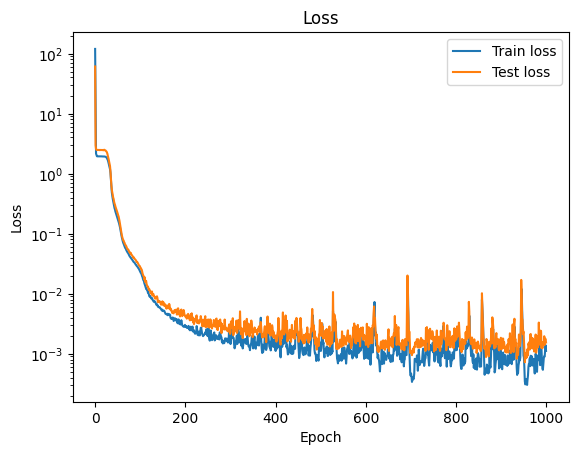

In [5]:
train_loss = np.load("POD_train_loss.npy")
test_loss = np.load("POD_test_loss.npy")
fig, ax = plt.subplots()
ax.plot(train_loss, label='Train loss')
ax.plot(test_loss, label='Test loss')
ax.set_title("Loss")
ax.set(xlabel="Epoch", ylabel="Loss")
ax.legend()
ax.set_yscale('log')

## Visualize the Deep Operator Network Predictions

We compare the prediction from our model to the truth on a sample from the test data set. The Python below formats the prediction for a MatLab script that produced the plot below.

In the first column on the left, we have the applied loading. The second column shows true displacements in both $X$ and $Y$ and the third column shows our model's predictions. In the fourth column, right, shows the error between the prediction and true value.

![A comparison of the Deep Operator Network predictions and the truth on a sample from the test data](Predictions_POD/TestCase8.png)

In [7]:
def eval_model(test_data, model):
    """Evaluate test data and save results"""
    model.eval()
    ux_pred_list = []
    uy_pred_list = []
    ux_test_list = []
    uy_test_list = []
    x_list = []
    for batch_number, (*x, y) in enumerate(test_data):
        ux_pred, uy_pred = model(*x)
        ux_test, uy_test = y
        ux_pred_list.append(ux_pred)
        uy_pred_list.append(uy_pred)
        ux_test_list.append(ux_test)
        uy_test_list.append(uy_test)
        x_list.append(x[1][:, 0, :])
    return torch.cat(ux_pred_list), torch.cat(uy_pred_list), torch.cat(ux_test_list), torch.cat(
        uy_test_list), torch.cat(x_list)

ux_pred, uy_pred, ux_test, uy_test, x_test = eval_model(test_data, model)
ux_pred = rescale(ux_pred.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_pred = rescale(uy_pred.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))
ux_test = rescale(ux_test.detach(), np.squeeze(ux_train_mean, axis=2), np.squeeze(ux_train_std, axis=2))
uy_test = rescale(uy_test.detach(), np.squeeze(uy_train_mean, axis=2), np.squeeze(uy_train_std, axis=2))

savemat('POD_Elastic_plate.mat',
        {'x_test': x_test.detach().numpy(), 
         'ux_test': ux_test.detach().numpy(), 
         'uy_test': uy_test.detach().numpy(),
         'ux_pred': ux_pred.detach().numpy(), 
         'uy_pred': uy_pred.detach().numpy()}
        )